# Chapter 6: Associators and synaptic plasticity

### Load needed modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

## 6.4: Synaptic scaling and weight distribution
### 6.4.2: Weight distributions in rate models

In real neurons, synapses have physical limits, but purely additive rules of STDP models do not enforce these bounds.

Therefore, synaptic scaling and normalization of the weight distribution becomes relevant to avoid runaway synaptic values (too large LTP/LTD) or  synaptic silencing (weights shrinking to 0)

The code below shows the weight distribution of synapses in a rate model following a normalized Hebbian covariance rule (eqn 6.23).
Mean of 0:

The synaptic weights have a mean of 0, as they are equally likely to be positive or negative. If the mean weight remains at 0 over time, it suggests a balanced network with no inherent bias toward excitation or inhibition.
Variance (Spread of Weights):

If STDP is applied, weights will evolve, but their distribution will remain roughly Gaussian if weight-dependent plasticity (e.g., normalization or synaptic scaling) is in place. Over time, certain weights may drift toward stronger positive or negative values, creating clusters of strongly reinforced synapses.


(Text(0.5, 0, 'w'), Text(0, 0.5, 'P(w)'))

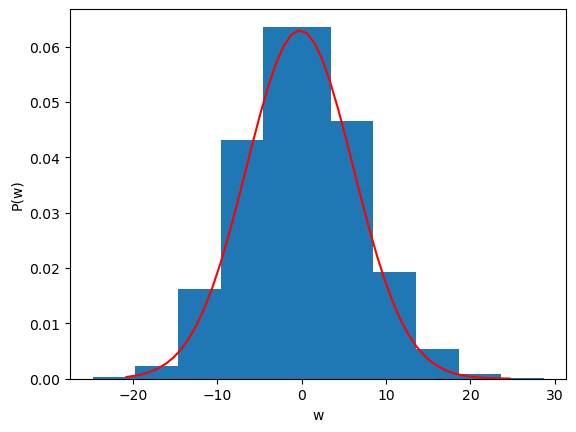

In [8]:
# Weight distribution of Hebbian synapses in rate model

nn=100; npat=1000 # number of nodes and patterns

rPre = np.random.exponential(10, (nn,npat)) # pre-synaptic rates
rPost = np.random.exponential(20, (nn,npat)) # post-synaptic rates
w=(rPost-np.mean(rPost))@(rPre-np.mean(rPre)).T/npat # Weights 

# Histogram plotting
n, bins = np.histogram(w)
dx = bins[1]-bins[0]
n = n/(sum(n)*dx)
x = np.zeros(10)
for i in range(10):
    x[i] = bins[i]+dx/2

plt.bar(x,n,8)

# Fit normal distribution to data
def func(x, mu, sig):
    return 1/(np.sqrt(2*np.pi)*sig)*np.exp(-(x-mu)**2/(2*sig**2))

popt, pcov = curve_fit(func, x, n)
x = np.linspace(x[0], x[9], 50)
plt.plot(x, func(x, *popt), 'r-')
plt.xlabel('w'), plt.ylabel('P(w)')

### 6.4.4: Oja’s rule and principal component analysis
Oja's rule introduces a normalization term that keeps synaptic weights bounded. Instead of just strengthening connections, it also slightly weakens them based on their current strength.

It helps in principal component analysis (PCA) by extracting dominant features from input signals, which is a relevant mechanism of information gain (vs. noise) in real neurons/populations.

It is a biologically plausible learning rule, because it respects local synaptic learning rules, maintains stable neural activity, promotes competition among synapses, and mirrors observed plasticity mechanisms in the brain.

(-1.0, 1.0, -1.0, 1.0)

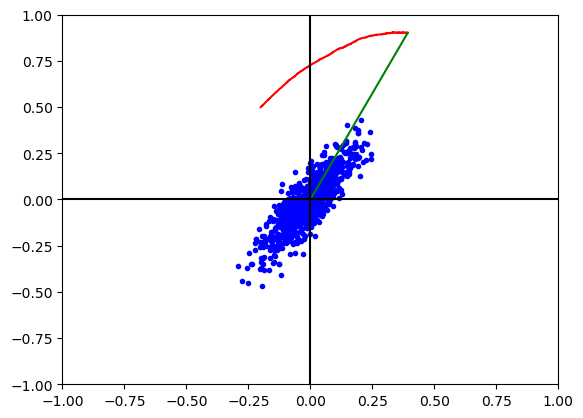

In [2]:
# PCA a la Oja

w = np.array([[-0.2,0.5]]).T; wTraj =w
a = -np.pi/6
rot = np.array([[np.cos(a),-np.sin(a)],
                [np.sin(a),np.cos(a)]])

# Training
for i in range(1000):
    rPre = 0.04*np.random.normal([0,0,],[1,4]);
    rPre = rot@rPre
    plt.plot(rPre[0],rPre[1],'b.')
    rPost = rPre@w
    w = w + 0.1*rPost*(rPre-rPost*w.T).T
    wTraj = np.append(wTraj,w,axis=1)

# Plotting results
plt.plot(wTraj[0,:],wTraj[1,:],'r')
plt.plot([0,w[0]],[0,w[1]],'g')
plt.plot([-1,1],[0,0],'k'); plt.plot([0,0],[-1,1],'k')
plt.axis([-1,1,-1,1])

## 6.5: Plasticity with pre- and postsynaptic dynamics
### Costa Model
It describes how synapses change their strength over time based on activity-dependent mechanisms.

- It is useful to model changes in synaptic strength based on the relative timing of presynaptic and postsynaptic spikes (STDP).

- It also models transient changes in synaptic strength due to recent activity (short-term plasticity).

- And takes into consideration the bounded strengthening or weakening of synapses to maintain network stability.

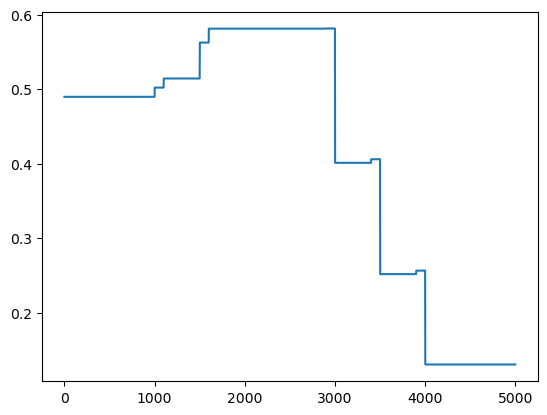

In [10]:
# Costa model of synaptic dynamics

tmax=500; dt=0.1
X = np.zeros(tmax*int(1/dt)); a = [500, 1000, 1500, 3000, 3500, 4000]; X[a] = 1
Y = np.zeros(tmax*int(1/dt)); b = [600, 1100, 1600, 2900, 3400, 3900]; Y[b] = 1

tauym = 32.7; tauyp = 230.2; tauxp = 66.6; D = 200; F = 50
cp = 0.0618; dp = 0.1548; dm = 0.1771
xp = np.array([0]); yp = np.array([0]); ym = np.array([0])
P = np.array([0.7]); q = np.array([0.7])
r = np.array([1]); p = np.array([P])

for t in range(0, tmax*int(1/dt)):

    xp = np.append(xp, xp[t]+dt*(-1/tauxp*xp[t])+X[t])
    yp = np.append(yp, yp[t]+dt*(-1/tauyp*yp[t])+Y[t])
    ym = np.append(ym, ym[t]+dt*(-1/tauym*ym[t])+Y[t])

    r = np.append(r, r[t]+dt*(1-r[t])/D - dt*X[t]*p[t]*r[t])
    p = np.append(p, p[t]+dt*(P[t]-p[t])/F + X[t]*P[t]*(1-p[t]))

    q = np.append(q, q[t]+Y[t]*cp*xp[t]*ym[t-1])
    P = np.append(P, P[t]+X[t]*(-dm*ym[t]+dp*xp[t-1])*yp[t])
    if P[-1]<0: P[-1]=0
    if P[-1]>1: P[-1]=1
    if q[-1]<0: q[-1]=0
    if q[-1]>2: q[-1]=2

plt.plot(P*q)

## Homework
Due Tuesday, Feb. 25, 11.00. Send to jperez@bcbl.eu in either .doc, .txt, or just by inserting it in the markdown cell below and sending me a copy of this notebook
1. What is an example of an experiment in which we can directly observe Hebbian learning? What would be one in which we can model/simulate Hebbian plasticity for a purpose more related to cognitive/behavioral/language processes?
2. Can long-term potentiation and long-term depression be induced separately? Do you think they occur naturally as two separate processes or as two sides of the same coin?
3. Speculate on an idea for an experiment whose results you could model with a Costa model.